In [1]:
import pandas as pd

In [2]:
import sqlite3

In [3]:
import random

In [4]:
import faker

In [5]:
f = faker.Faker()

In [6]:
cities = [f.city() for _ in range(5)]

In [7]:
df = pd.read_csv('horaire.csv')

In [8]:
df = pd.read_csv('horaire_data.csv')

In [9]:
df

,produit,date,horaire
0,Lake Lisa,2020-11-12,16
1,Christymouth,2020-10-09,3
2,Baileychester,2020-10-29,2
3,Ballchester,2020-10-29,4
4,Markchester,2020-01-30,1


In [10]:
df['date'] = pd.to_datetime(df['date'])

In [11]:
df['produit'] = cities

In [12]:
df

,produit,date,horaire
0,New Hollyside,2020-11-12,16
1,Port Rebecca,2020-10-09,3
2,South Anthonymouth,2020-10-29,2
3,New Granttown,2020-10-29,4
4,Frenchport,2020-01-30,1


In [13]:
df.to_csv('horaire_data.csv',index=False)

In [14]:
connection = sqlite3.connect('horaire.db')

In [15]:
df[['date', 'produit']].to_sql('inventory_check', con=connection, if_exists='replace', index=False)

In [16]:
pd.Series([pd.Timedelta(random.randint(7,20), 'D') for i in range(5)])

0   17 days
1    7 days
2    9 days
3    7 days
4   16 days
dtype: timedelta64[ns]

In [17]:
new_df = pd.DataFrame()
new_df['produit'] = df['produit']
new_df['date'] = df['date']+pd.Series([pd.Timedelta(random.randint(7,20), 'D') for i in range(5)])

In [18]:
new_df

,produit,date
0,New Hollyside,2020-11-26
1,Port Rebecca,2020-10-25
2,South Anthonymouth,2020-11-06
3,New Granttown,2020-11-17
4,Frenchport,2020-02-11


In [19]:
new_df.to_sql('inventory_check', con=connection, if_exists='append', index=False)

In [20]:
checks = pd.read_sql('SELECT * from inventory_check', con = connection)

In [21]:
checks['date'] = pd.to_datetime(checks['date'])

In [22]:
checks

,date,produit
0,2020-11-12,New Hollyside
1,2020-10-09,Port Rebecca
2,2020-10-29,South Anthonymouth
3,2020-10-29,New Granttown
4,2020-01-30,Frenchport
5,2020-11-26,New Hollyside
6,2020-10-25,Port Rebecca
7,2020-11-06,South Anthonymouth
8,2020-11-17,New Granttown
9,2020-02-11,Frenchport


In [23]:
last_checked = checks.sort_values('date').groupby(['produit']).last().reset_index()

In [24]:
last_checked

,produit,date
0,Frenchport,2020-02-11
1,New Granttown,2020-11-17
2,New Hollyside,2020-11-26
3,Port Rebecca,2020-10-25
4,South Anthonymouth,2020-11-06


In [25]:
merged = df.merge(last_checked, on='produit', suffixes=('_initial','_checked'))

In [26]:
merged

,produit,date_initial,horaire,date_checked
0,New Hollyside,2020-11-12,16,2020-11-26
1,Port Rebecca,2020-10-09,3,2020-10-25
2,South Anthonymouth,2020-10-29,2,2020-11-06
3,New Granttown,2020-10-29,4,2020-11-17
4,Frenchport,2020-01-30,1,2020-02-11


In [27]:
today = pd.Timestamp.today()

In [28]:
merged['week_difference'] = (today - merged['date_checked']).dt.days/7 

In [29]:
merged

,produit,date_initial,horaire,date_checked,week_difference
0,New Hollyside,2020-11-12,16,2020-11-26,2.857143
1,Port Rebecca,2020-10-09,3,2020-10-25,7.428571
2,South Anthonymouth,2020-10-29,2,2020-11-06,5.714286
3,New Granttown,2020-10-29,4,2020-11-17,4.142857
4,Frenchport,2020-01-30,1,2020-02-11,44.142857


In [30]:
merged['need_to_check'] = merged['week_difference'] > merged['horaire']

In [31]:
merged

,produit,date_initial,horaire,date_checked,week_difference,need_to_check
0,New Hollyside,2020-11-12,16,2020-11-26,2.857143,False
1,Port Rebecca,2020-10-09,3,2020-10-25,7.428571,True
2,South Anthonymouth,2020-10-29,2,2020-11-06,5.714286,True
3,New Granttown,2020-10-29,4,2020-11-17,4.142857,True
4,Frenchport,2020-01-30,1,2020-02-11,44.142857,True


In [32]:
schedules = []
for i, row in merged.iterrows():
    schedule = pd.date_range(row['date_checked'], today+pd.Timedelta(52, 'W'), freq=f'{row["horaire"]*7}D')
    schedule = schedule[schedule >= today]
    schedules.append(schedule)

In [33]:
total = []
for schedule in schedules:
    for day in schedule:
        total.append((day, 1))

In [34]:
schedule_df = pd.DataFrame(total, columns=['date', 'check'])

schedule_series = pd.Series(schedule_df['check'])
schedule_series.index = schedule_df['date']

In [35]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,10)

In [36]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

def main():
    dates, data = generate_data()
    fig, ax = plt.subplots(figsize=(10, 10))
    calendar_heatmap(ax, dates, data)
    plt.show()

def generate_data():
    num = 100
    data = np.random.randint(0, 20, num)
    start = dt.datetime(2015, 3, 1)
    dates = [start + dt.timedelta(days=i) for i in range(num)]
    return dates, data

def calendar_array(dates, data):
    i, j = zip(*[d.isocalendar()[1:] for d in dates])
    i = np.array(i) - min(i)
    j = np.array(j) - 1
    ni = max(i) + 1

    calendar = np.nan * np.zeros((ni, 7))
    calendar[i, j] = data
    return i, j, calendar


def calendar_heatmap(ax, dates, data):
    i, j, calendar = calendar_array(dates, data)
    im = ax.imshow(calendar, interpolation='none', cmap='summer')
    label_days(ax, dates, i, j, calendar)
    label_months(ax, dates, i, j, calendar)
    ax.figure.colorbar(im, fraction=0.016, pad=0.04)
    #plt.colorbar(im,fraction=0.046, pad=0.04)
    
def label_days(ax, dates, i, j, calendar):
    ni, nj = calendar.shape
    day_of_month = np.nan * np.zeros((ni, 7))
    day_of_month[i, j] = [d.day for d in dates]

    for (i, j), day in np.ndenumerate(day_of_month):
        if np.isfinite(day):
            ax.text(j, i, int(day), ha='center', va='center')

    ax.set(xticks=np.arange(7), 
           xticklabels=['L', 'M', 'M', 'J', 'V', 'S', 'D'])
    ax.xaxis.tick_top()

def label_months(ax, dates, i, j, calendar):
    month_labels = np.array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                             'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    months = np.array([d.month for d in dates])
    uniq_months = sorted(set(months))
    yticks = [i[months == m].mean() for m in months]
    dates_df = pd.DataFrame(dates)
    dates_df.index = dates_df[0]
    new_months = dates_df.resample('7D').sum().index.values
    new_months = pd.Series(new_months).dt.month
    labels = [month_labels[m - 1] for m in new_months]
    locs, oldlabels = plt.yticks()
    new_labels = []
    for loc in locs:
        if loc < 0:
            loc = 0
        if loc >= len(labels):
            loc = len(labels)-1
        new_labels.append(labels[int(loc)])
    plt.yticks(locs, new_labels, rotation=90)    

def my_calendar(dates, data):
    fig, ax = plt.subplots(figsize=(30, 30))
    plt.locator_params(nbins=30)
    calendar_heatmap(ax, dates, data)
    plt.show()

In [182]:
resampled = schedule_series.resample('D').sum()

In [164]:
import datetime

In [178]:
dates = resampled.index.to_list()

In [179]:
data = resampled.values

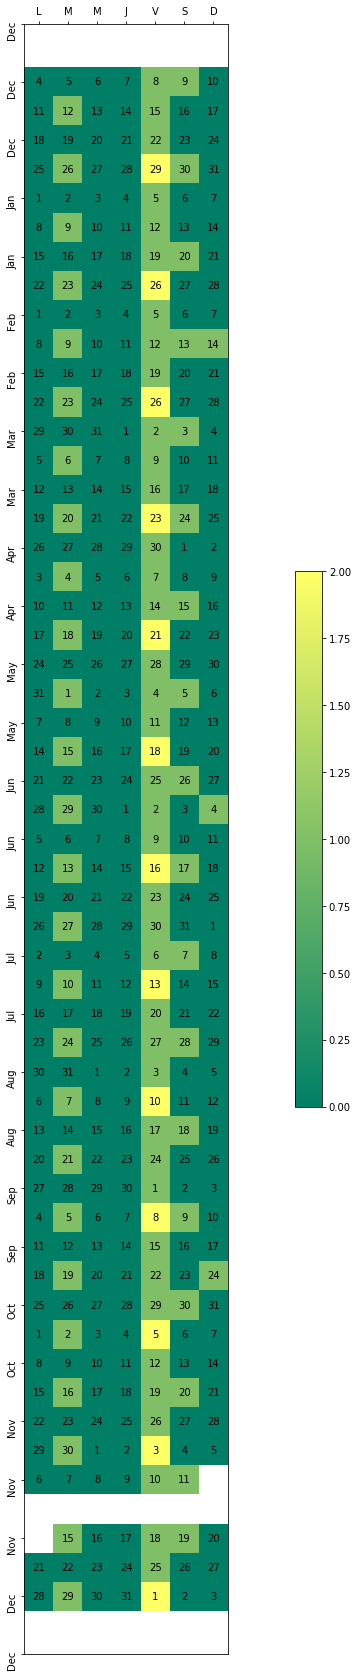

In [198]:
my_calendar(dates, data)